# Visualización de Resultados de Modelos

Este notebook permite cargar y visualizar los resultados de entrenamiento de los modelos de clasificación de estadios de sueño.

Carga métricas desde archivos JSON generados por `src/models.py` y genera visualizaciones interactivas.

**Modelos soportados:**
- Random Forest
- XGBoost  
- CNN1D (Deep Learning)
- LSTM (Deep Learning)


## Configuración inicial


In [32]:
import json
from pathlib import Path
from statistics import NormalDist

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

sns.set_theme(style="whitegrid", palette="deep")

PROJECT_ROOT = Path("..").resolve()
MODELS_DIR = PROJECT_ROOT / "models"
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"

STAGE_ORDER = ["W", "N1", "N2", "N3", "REM"]
STAGE_COLORS = {
    "W": "#fdae61",
    "N1": "#fee090",
    "N2": "#abd9e9",
    "N3": "#2c7bb6",
    "REM": "#d7191c",
}

EPS = 1e-12


def load_metrics(path: Path) -> dict:
    """Carga métricas desde un archivo JSON."""
    with open(path) as f:
        return json.load(f)


def wilson_ci(
    successes: float, total: float, alpha: float = 0.05
) -> tuple[float, float]:
    """Intervalo de confianza de Wilson para proporciones (binomial)."""
    if total <= 0:
        return (np.nan, np.nan)
    z = NormalDist().inv_cdf(1 - alpha / 2)
    phat = successes / total
    denom = 1 + (z**2) / total
    center = (phat + (z**2) / (2 * total)) / denom
    margin = (
        z * np.sqrt((phat * (1 - phat) / total) + ((z**2) / (4 * total**2)))
    ) / denom
    return (max(0, center - margin), min(1, center + margin))


def compute_class_metrics(
    cm: np.ndarray, labels=STAGE_ORDER, alpha: float = 0.05
) -> pd.DataFrame:
    """Calcula métricas por clase a partir de la matriz de confusión."""
    cm = np.asarray(cm)
    metrics = []
    for idx, label in enumerate(labels):
        tp = cm[idx, idx]
        fn = cm[idx, :].sum() - tp
        fp = cm[:, idx].sum() - tp
        tn = cm.sum() - tp - fn - fp

        support = tp + fn
        predicted = tp + fp

        precision = tp / (predicted + EPS)
        recall = tp / (support + EPS)
        specificity = tn / (tn + fp + EPS)
        npv = tn / (tn + fn + EPS)
        f1 = 2 * precision * recall / (precision + recall + EPS)
        fpr = fp / (fp + tn + EPS)
        fnr = fn / (fn + tp + EPS)
        fdr = fp / (fp + tp + EPS)

        recall_ci_low, recall_ci_high = wilson_ci(tp, support, alpha=alpha)
        spec_ci_low, spec_ci_high = wilson_ci(tn, tn + fp, alpha=alpha)

        metrics.append(
            {
                "Stage": label,
                "support": support,
                "precision": precision,
                "recall": recall,
                "specificity": specificity,
                "npv": npv,
                "f1": f1,
                "fpr": fpr,
                "fnr": fnr,
                "fdr": fdr,
                "recall_ci_low": recall_ci_low,
                "recall_ci_high": recall_ci_high,
                "spec_ci_low": spec_ci_low,
                "spec_ci_high": spec_ci_high,
            }
        )

    return pd.DataFrame(metrics)


def summarize_class_metrics(df: pd.DataFrame) -> dict[str, float]:
    """Resumen macro con métricas robustas a desbalance (balanced accuracy)."""
    n_classes = len(df)
    chance = 1 / n_classes if n_classes else np.nan
    balanced_accuracy = df["recall"].mean()
    macro_specificity = df["specificity"].mean()
    return {
        "balanced_accuracy": balanced_accuracy,
        "macro_specificity": macro_specificity,
        "macro_precision": df["precision"].mean(),
        "macro_f1": df["f1"].mean(),
        "gmean_sens_spec": np.sqrt(balanced_accuracy * macro_specificity),
        "chance_accuracy": chance,
        "balanced_accuracy_lift": (balanced_accuracy / chance - 1)
        if chance
        else np.nan,
    }


def most_confused_pairs(
    cm: np.ndarray, labels=STAGE_ORDER, top_n: int = 5
) -> pd.DataFrame:
    """Top pares de confusión (verdadero vs predicho) ordenados por frecuencia."""
    cm = np.asarray(cm)
    records = []
    for i, true_label in enumerate(labels):
        row_sum = cm[i, :].sum()
        for j, pred_label in enumerate(labels):
            if i == j:
                continue
            count = int(cm[i, j])
            if count > 0:
                records.append(
                    {
                        "Verdadero": true_label,
                        "Predicho": pred_label,
                        "Conteo": count,
                        "Proporción_sobre_clase": count / (row_sum + EPS),
                    }
                )

    if not records:
        return pd.DataFrame(
            columns=["Verdadero", "Predicho", "Conteo", "Proporción_sobre_clase"]
        )

    df = pd.DataFrame(records)
    return df.sort_values(by="Conteo", ascending=False).head(top_n)


def _latest_dir(base_dir: Path, glob_pattern: str) -> Path | None:
    candidates = [p for p in base_dir.glob(glob_pattern) if p.is_dir()]
    if not candidates:
        return None
    return max(candidates, key=lambda p: p.stat().st_mtime)


def _latest_json_in_dir(
    dir_path: Path | None, glob_pattern: str = "*_results.json"
) -> Path | None:
    if dir_path is None or not dir_path.exists():
        return None
    candidates = [p for p in dir_path.glob(glob_pattern) if p.is_file()]
    if not candidates:
        return None
    return max(candidates, key=lambda p: p.stat().st_mtime)


cnn1d_dir = _latest_dir(ARTIFACTS_DIR, "cnn1d_full_*_artifacts")

MODEL_PATHS = {
    "random_forest": MODELS_DIR / "rf_opt_bayes_best" / "random_forest_metrics.json",
    "xgboost": MODELS_DIR / "xgb_loso_best" / "xgboost_metrics.json",
    "cnn1d": _latest_json_in_dir(cnn1d_dir),
    "lstm_unidir": _latest_json_in_dir(ARTIFACTS_DIR / "lstm_full_unidir_artifacts"),
    "lstm_bidir": _latest_json_in_dir(ARTIFACTS_DIR / "lstm_full_bidir_artifacts"),
    "lstm_bidir_attention": _latest_json_in_dir(
        ARTIFACTS_DIR / "lstm_full_bidir_attention_artifacts"
    ),
}

AVAILABLE_MODELS = list(MODEL_PATHS.keys())
print("Modelos disponibles:", AVAILABLE_MODELS)
print("Disponibilidad de archivos:")
for name, path in MODEL_PATHS.items():
    status = "✓" if isinstance(path, Path) and path.exists() else "✗"
    print(f"  {status} {name}: {path}")

Modelos disponibles: ['random_forest', 'xgboost', 'cnn1d', 'lstm_unidir', 'lstm_bidir', 'lstm_bidir_attention']
Disponibilidad de archivos:
  ✓ random_forest: /Users/gscm/Documents/GitHub/sleep-ST/models/rf_opt_bayes_best/random_forest_metrics.json
  ✓ xgboost: /Users/gscm/Documents/GitHub/sleep-ST/models/xgb_loso_best/xgboost_metrics.json
  ✓ cnn1d: /Users/gscm/Documents/GitHub/sleep-ST/artifacts/cnn1d_full_20251210_201502_artifacts/cnn1d_full_20251210_201502_results.json
  ✓ lstm_unidir: /Users/gscm/Documents/GitHub/sleep-ST/artifacts/lstm_full_unidir_artifacts/lstm_full_20251210_193039_results.json
  ✓ lstm_bidir: /Users/gscm/Documents/GitHub/sleep-ST/artifacts/lstm_full_bidir_artifacts/lstm_full_20251211_031820_results.json
  ✓ lstm_bidir_attention: /Users/gscm/Documents/GitHub/sleep-ST/artifacts/lstm_full_bidir_attention_artifacts/lstm_full_20251211_145034_results.json


## Cargar métricas de un modelo


In [33]:
# Cambiar según el modelo que quieras visualizar
model_type = "xgboost"  # Opciones: "random_forest", "xgboost", "cnn1d", "lstm_unidir", "lstm_bidir", "lstm_bidir_attention"
selected_model_type = model_type

metrics = {}
metrics_path = MODEL_PATHS.get(model_type)

if isinstance(metrics_path, Path) and metrics_path.exists():
    metrics = load_metrics(metrics_path)
    print(f"Métricas cargadas para {model_type}")
    print(f"Timestamp: {metrics.get('timestamp', 'N/A')}")
    print(
        f"Tipo de modelo: {metrics.get('model_type', metrics.get('model_name', 'N/A'))}"
    )
    print(
        f"Parámetros/Config: {metrics.get('model_params', metrics.get('config', {}))}"
    )
else:
    print(f"No se encontró archivo de métricas para {model_type}")
    print(f"Path buscado: {metrics_path}")
    print("\nModelos disponibles con archivos:")
    for name, path in MODEL_PATHS.items():
        status = "✓" if isinstance(path, Path) and path.exists() else "✗"
        print(f"  {status} {name}: {path}")

Métricas cargadas para xgboost
Timestamp: 2025-12-08T18:37:24.109095
Tipo de modelo: xgboost
Parámetros/Config: {'n_estimators': 413, 'max_depth': 10, 'n_iter_optimize': 50, 'cv_folds_optimize': 3, 'optimize_storage': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'class_weight': None, 'learning_rate': 0.03313286416029904, 'subsample': 0.7443736026906934, 'colsample_bytree': 0.6223142659283984, 'min_child_weight': 4.0, 'gamma': 0.7123076394393054, 'reg_alpha': 0.00048606238525281066, 'reg_lambda': 0.026977435708790857, 'scale_pos_weight': None}


## Métricas generales


In [34]:
if "metrics" in metrics:
    m = metrics["metrics"]
    print("=" * 60)
    print("MÉTRICAS GENERALES")
    print("=" * 60)
    print(f"Accuracy:        {m.get('accuracy', 0):.4f}")
    print(f"Cohen's Kappa:   {m.get('kappa', 0):.4f}")
    print(f"F1-score (macro): {m.get('f1_macro', 0):.4f}")
    print(f"F1-score (weighted): {m.get('f1_weighted', 0):.4f}")

    if "cv_results" in metrics:
        cv = metrics["cv_results"]
        print("\nCross-Validation:")
        print(
            f"  Mean F1-macro: {cv.get('mean_score', 0):.4f} ± {cv.get('std_score', 0):.4f}"
        )

MÉTRICAS GENERALES
Accuracy:        0.7308
Cohen's Kappa:   0.6412
F1-score (macro): 0.7002
F1-score (weighted): 0.7374

Cross-Validation:
  Mean F1-macro: 0.6796 ± 0.0985


## Matriz de confusión


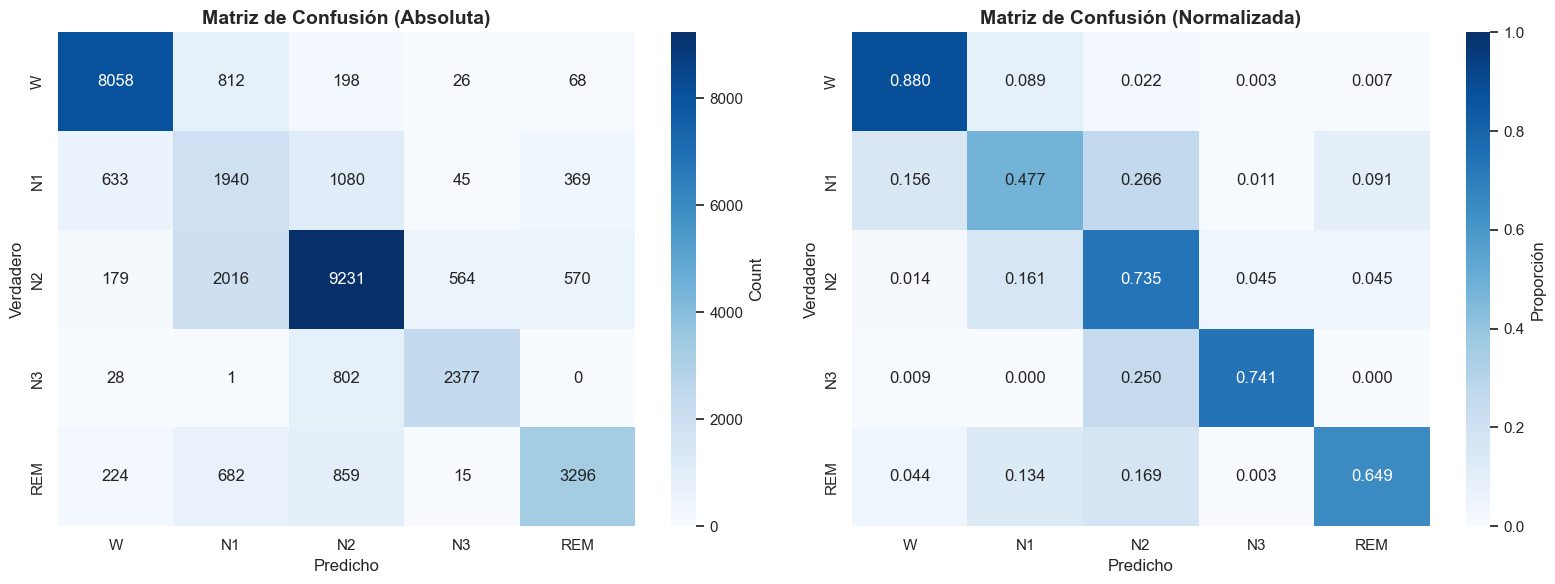

In [35]:
if "confusion_matrix" in metrics:
    cm = np.array(metrics["confusion_matrix"])

    # Normalizar por filas (recall por clase)
    cm_normalized = cm.astype("float") / (cm.sum(axis=1)[:, np.newaxis] + 1e-10)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Matriz absoluta
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=STAGE_ORDER,
        yticklabels=STAGE_ORDER,
        ax=axes[0],
        cbar_kws={"label": "Count"},
    )
    axes[0].set_title("Matriz de Confusión (Absoluta)", fontsize=14, fontweight="bold")
    axes[0].set_ylabel("Verdadero", fontsize=12)
    axes[0].set_xlabel("Predicho", fontsize=12)

    # Matriz normalizada
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".3f",
        cmap="Blues",
        xticklabels=STAGE_ORDER,
        yticklabels=STAGE_ORDER,
        ax=axes[1],
        cbar_kws={"label": "Proporción"},
        vmin=0,
        vmax=1,
    )
    axes[1].set_title(
        "Matriz de Confusión (Normalizada)", fontsize=14, fontweight="bold"
    )
    axes[1].set_ylabel("Verdadero", fontsize=12)
    axes[1].set_xlabel("Predicho", fontsize=12)

    plt.tight_layout()
    plt.show()

## Análisis complementario

Se amplía el análisis para interpretar los resultados con mayor rigor: métricas derivadas de la matriz de confusión (recall, especificidad, precisión, NPV, tasas de error), intervalos de confianza binomiales (Wilson) por clase, balanceo de desempeño (balanced accuracy) y pares de confusión más frecuentes que indican errores sistemáticos.


Distribución de soportes por clase:


,Stage,support,proportion
0,W,"9,162",26.89%
1,N1,"4,067",11.94%
2,N2,"12,560",36.86%
3,N3,"3,208",9.42%
4,REM,"5,076",14.90%



Métricas por clase con IC 95% (Wilson):


,Stage,precision,recall,specificity,npv (TN rate),f1,fpr,fnr,fdr,recall_ci_low,recall_ci_high,spec_ci_low,spec_ci_high
0,W,0.883,0.880,0.957,0.956,0.881,0.043,0.120,0.117,0.873,0.886,0.955,0.960
1,N1,0.356,0.477,0.883,0.926,0.408,0.117,0.523,0.644,0.462,0.492,0.879,0.887
2,N2,0.759,0.735,0.863,0.848,0.747,0.137,0.265,0.241,0.727,0.743,0.859,0.868
3,N3,0.785,0.741,0.979,0.973,0.762,0.021,0.259,0.215,0.726,0.756,0.977,0.980
4,REM,0.766,0.649,0.965,0.940,0.703,0.035,0.351,0.234,0.636,0.662,0.963,0.967



Resumen macro robusto:
Balanced accuracy (sensibilidad macro): 0.696
Especificidad macro: 0.930
Precisión macro: 0.710
F1 macro: 0.700
G-mean (sensibilidad x especificidad): 0.805
Azar (1/n clases): 0.200
Lift sobre azar (balanced acc): 2.482


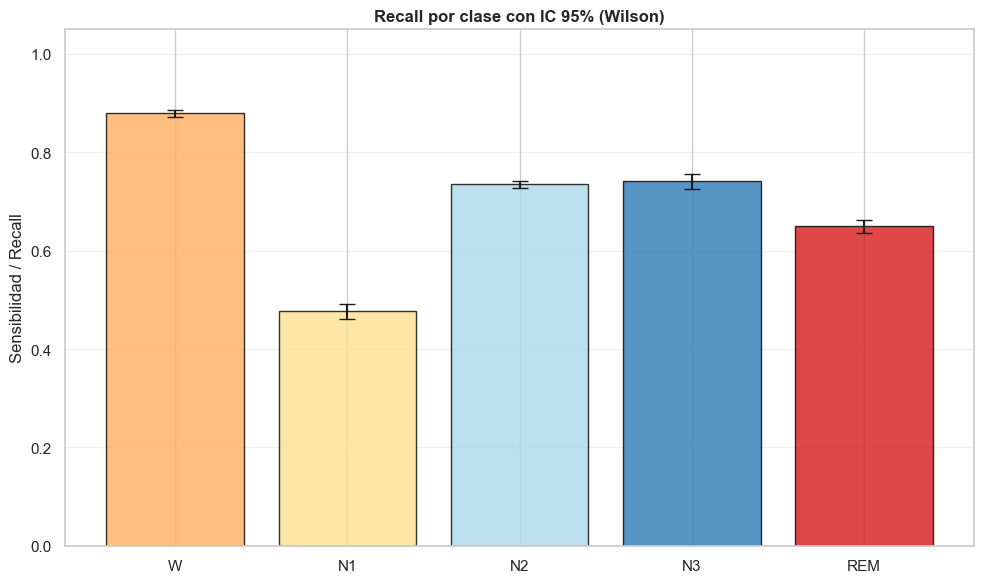


Pares de confusión más frecuentes:


,Verdadero,Predicho,Conteo,Proporción_sobre_clase
9,N2,N1,"2,016",16.05%
5,N1,N2,"1,080",26.56%
17,REM,N2,859,16.92%
0,W,N1,812,8.86%
14,N3,N2,802,25.00%


In [36]:
alpha = 0.05  # IC 95%
if "confusion_matrix" in metrics:
    cm = np.array(metrics["confusion_matrix"])
    class_metrics = compute_class_metrics(cm, labels=STAGE_ORDER, alpha=alpha)
    summary = summarize_class_metrics(class_metrics)

    # Distribución de soportes por clase
    support_df = class_metrics[["Stage", "support"]].copy()
    support_df["proportion"] = support_df["support"] / support_df["support"].sum()
    print("Distribución de soportes por clase:")
    display(
        support_df.style.format(
            {"support": "{:,.0f}", "proportion": "{:.2%}"}
        ).background_gradient(cmap="Purples", subset=["proportion"])
    )

    # Métricas por clase con IC 95% (Wilson)
    print("\nMétricas por clase con IC 95% (Wilson):")
    display(
        class_metrics[
            [
                "Stage",
                "precision",
                "recall",
                "specificity",
                "npv",
                "f1",
                "fpr",
                "fnr",
                "fdr",
                "recall_ci_low",
                "recall_ci_high",
                "spec_ci_low",
                "spec_ci_high",
            ]
        ]
        .rename(columns={"npv": "npv (TN rate)", "fpr": "fpr", "fnr": "fnr"})
        .style.format(
            {
                "precision": "{:.3f}",
                "recall": "{:.3f}",
                "specificity": "{:.3f}",
                "npv (TN rate)": "{:.3f}",
                "f1": "{:.3f}",
                "fpr": "{:.3f}",
                "fnr": "{:.3f}",
                "fdr": "{:.3f}",
                "recall_ci_low": "{:.3f}",
                "recall_ci_high": "{:.3f}",
                "spec_ci_low": "{:.3f}",
                "spec_ci_high": "{:.3f}",
            }
        )
        .background_gradient(
            cmap="YlGnBu",
            subset=["precision", "recall", "specificity", "npv (TN rate)", "f1"],
        )
    )

    # Resumen macro robusto y lift sobre azar
    print("\nResumen macro robusto:")
    summary_labels = {
        "balanced_accuracy": "Balanced accuracy (sensibilidad macro)",
        "macro_specificity": "Especificidad macro",
        "macro_precision": "Precisión macro",
        "macro_f1": "F1 macro",
        "gmean_sens_spec": "G-mean (sensibilidad x especificidad)",
        "chance_accuracy": "Azar (1/n clases)",
        "balanced_accuracy_lift": "Lift sobre azar (balanced acc)",
    }
    for key, label in summary_labels.items():
        value = summary.get(key, np.nan)
        if pd.isna(value):
            print(f"{label}: N/A")
        else:
            print(f"{label}: {value:.3f}")

    # Gráfico de sensibilidad por clase con IC 95%
    colors = [STAGE_COLORS.get(stage, "gray") for stage in STAGE_ORDER]
    fig, ax = plt.subplots(figsize=(10, 6))
    yerr = np.vstack(
        [
            class_metrics["recall"] - class_metrics["recall_ci_low"],
            class_metrics["recall_ci_high"] - class_metrics["recall"],
        ]
    )
    ax.bar(
        class_metrics["Stage"],
        class_metrics["recall"],
        color=colors,
        edgecolor="black",
        alpha=0.8,
        yerr=yerr,
        capsize=6,
    )
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Sensibilidad / Recall")
    ax.set_title("Recall por clase con IC 95% (Wilson)", fontweight="bold")
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Pares de confusión más frecuentes (errores sistemáticos)
    conf_df = most_confused_pairs(cm, labels=STAGE_ORDER, top_n=5)
    print("\nPares de confusión más frecuentes:")
    if not conf_df.empty:
        display(
            conf_df.style.format(
                {"Conteo": "{:,.0f}", "Proporción_sobre_clase": "{:.2%}"}
            ).background_gradient(
                cmap="Reds", subset=["Conteo", "Proporción_sobre_clase"]
            )
        )
    else:
        print("No se registran confusiones relevantes (fuera de la diagonal).")
else:
    print("No hay matriz de confusión disponible en las métricas.")

## Comparar múltiples modelos


✓ Cargado: random_forest
✓ Cargado: xgboost
✓ Cargado: cnn1d
✓ Cargado: lstm_unidir
✓ Cargado: lstm_bidir
✓ Cargado: lstm_bidir_attention

Total de modelos cargados: 6


,Modelo,Accuracy,Kappa,F1-macro,F1-weighted
0,random_forest,0.7282,0.6347,0.6950,0.7335
1,xgboost,0.7308,0.6412,0.7002,0.7374
2,cnn1d,0.7686,0.6802,0.7083,0.7743
3,lstm_unidir,0.6617,0.5296,0.5859,0.6585
4,lstm_bidir,0.6541,0.5211,0.5818,0.6624
5,lstm_bidir_attention,0.7464,0.6514,0.6807,0.7512


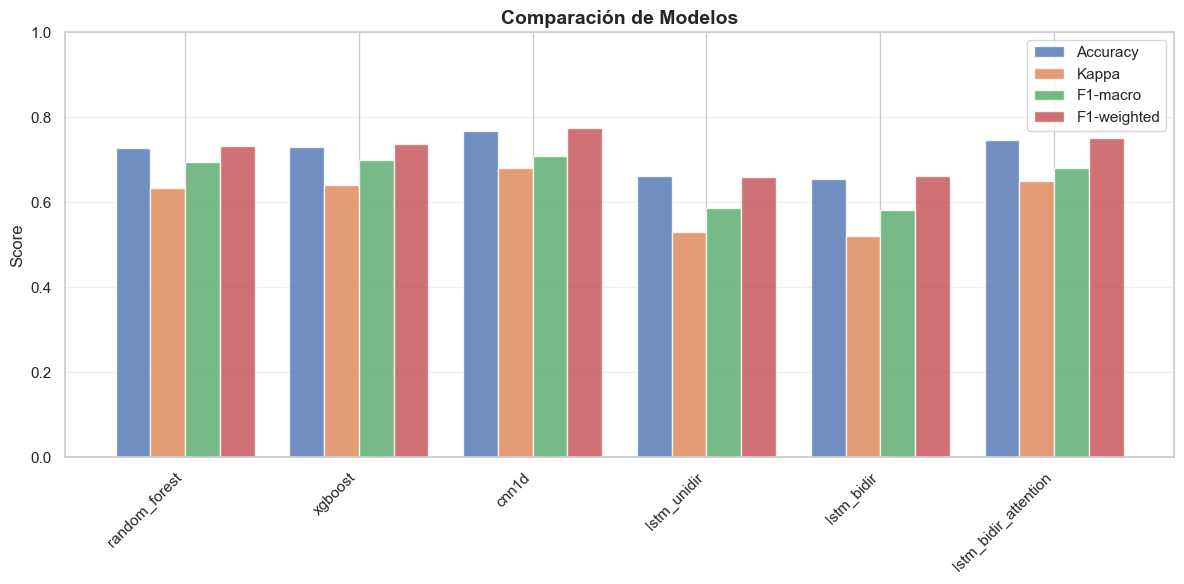

In [37]:
# Cargar métricas de todos los modelos disponibles
all_metrics = {}
for model_key, metrics_path in MODEL_PATHS.items():
    if not isinstance(metrics_path, Path):
        continue
    if not metrics_path.exists():
        continue
    all_metrics[model_key] = load_metrics(metrics_path)
    print(f"✓ Cargado: {model_key}")

print(f"\nTotal de modelos cargados: {len(all_metrics)}")

if len(all_metrics) > 1:
    # Comparar métricas generales
    comparison = []
    for name, m in all_metrics.items():
        if "metrics" in m:
            comparison.append(
                {
                    "Modelo": name,
                    "Accuracy": m["metrics"].get("accuracy", 0),
                    "Kappa": m["metrics"].get("kappa", 0),
                    "F1-macro": m["metrics"].get("f1_macro", 0),
                    "F1-weighted": m["metrics"].get("f1_weighted", 0),
                }
            )

    if comparison:
        df_comp = pd.DataFrame(comparison)
        display(
            df_comp.style.format(
                {
                    "Accuracy": "{:.4f}",
                    "Kappa": "{:.4f}",
                    "F1-macro": "{:.4f}",
                    "F1-weighted": "{:.4f}",
                }
            ).background_gradient(
                cmap="RdYlGn", subset=["Accuracy", "Kappa", "F1-macro", "F1-weighted"]
            )
        )

        # Gráfico comparativo
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(df_comp))
        width = 0.2

        metrics_to_plot = ["Accuracy", "Kappa", "F1-macro", "F1-weighted"]
        for i, metric in enumerate(metrics_to_plot):
            ax.bar(x + i * width, df_comp[metric], width, label=metric, alpha=0.8)

        ax.set_ylabel("Score", fontsize=12)
        ax.set_title("Comparación de Modelos", fontsize=14, fontweight="bold")
        ax.set_xticks(x + width * 1.5)
        ax.set_xticklabels(df_comp["Modelo"], rotation=45, ha="right")
        ax.legend()
        ax.grid(axis="y", alpha=0.3)
        ax.set_ylim([0, 1])

        plt.tight_layout()
        plt.show()
else:
    print("Necesitas al menos 2 modelos para comparar")

In [38]:
# Resumen cuantitativo para conclusiones (compacto)
print("=" * 70)
print("RESUMEN CUANTITATIVO")
print("=" * 70)

# 1) Modelo actualmente seleccionado
selected = selected_model_type if "selected_model_type" in globals() else model_type
timestamp = metrics.get("timestamp", "N/A")
m = metrics.get("metrics", {})
print(f"Modelo seleccionado: {selected} | timestamp: {timestamp}")
print(
    f"Accuracy={m.get('accuracy', float('nan')):.4f} | Kappa={m.get('kappa', float('nan')):.4f} | F1-macro={m.get('f1_macro', float('nan')):.4f} | F1-weighted={m.get('f1_weighted', float('nan')):.4f}"
)
if "cv_results" in metrics:
    cv = metrics["cv_results"]
    if "mean_score" in cv and "std_score" in cv:
        print(f"CV (F1-macro): {cv['mean_score']:.4f} ± {cv['std_score']:.4f}")

# 2) Desempeño por clase (recall)
if "class_metrics" in globals():
    cm_df = class_metrics.set_index("Stage")
    recalls = cm_df["recall"].to_dict()
    worst_stage = min(recalls, key=recalls.get)
    best_stage = max(recalls, key=recalls.get)
    print("\nRecall por estadio (ordenado):")
    for stage, val in sorted(recalls.items(), key=lambda kv: kv[1], reverse=True):
        print(f"  {stage}: {val:.3f}")
    print(
        f"Peor recall: {worst_stage} ({recalls[worst_stage]:.3f}) | Mejor recall: {best_stage} ({recalls[best_stage]:.3f})"
    )

# 3) Balanced accuracy / lift (si existe)
if "summary" in globals():
    print("\nResumen macro robusto:")
    print(f"  balanced_accuracy={summary.get('balanced_accuracy', float('nan')):.3f}")
    print(f"  macro_specificity={summary.get('macro_specificity', float('nan')):.3f}")
    print(f"  gmean_sens_spec={summary.get('gmean_sens_spec', float('nan')):.3f}")
    print(f"  chance_accuracy={summary.get('chance_accuracy', float('nan')):.3f}")
    print(
        f"  balanced_accuracy_lift={summary.get('balanced_accuracy_lift', float('nan')):.3f}"
    )

# 4) Pares de confusión más frecuentes (conteos)
if "cm" in globals():
    top_conf = most_confused_pairs(cm, labels=STAGE_ORDER, top_n=8)
    print("\nTop confusiones (conteo y proporción sobre clase verdadera):")
    if top_conf.empty:
        print("  (sin confusiones fuera de la diagonal)")
    else:
        for _, row in top_conf.iterrows():
            print(
                f"  {row['Verdadero']} → {row['Predicho']}: {int(row['Conteo'])} ({row['Proporción_sobre_clase']:.2%})"
            )

# 5) Ranking entre modelos cargados (si está df_comp)
if "df_comp" in globals() and not df_comp.empty:
    print("\nRanking por F1-macro:")
    rank_f1 = df_comp.sort_values(by="F1-macro", ascending=False).reset_index(drop=True)
    print(
        rank_f1[["Modelo", "F1-macro", "Kappa", "Accuracy"]].to_string(
            index=False,
            formatters={
                "F1-macro": "{:.4f}".format,
                "Kappa": "{:.4f}".format,
                "Accuracy": "{:.4f}".format,
            },
        )
    )
    best = rank_f1.iloc[0]
    worst = rank_f1.iloc[-1]
    print(f"\nMejor F1-macro: {best['Modelo']} ({best['F1-macro']:.4f})")
    print(f"Peor F1-macro: {worst['Modelo']} ({worst['F1-macro']:.4f})")

RESUMEN CUANTITATIVO
Modelo seleccionado: xgboost | timestamp: 2025-12-08T18:37:24.109095
Accuracy=0.7308 | Kappa=0.6412 | F1-macro=0.7002 | F1-weighted=0.7374
CV (F1-macro): 0.6796 ± 0.0985

Recall por estadio (ordenado):
  W: 0.880
  N3: 0.741
  N2: 0.735
  REM: 0.649
  N1: 0.477
Peor recall: N1 (0.477) | Mejor recall: W (0.880)

Resumen macro robusto:
  balanced_accuracy=0.696
  macro_specificity=0.930
  gmean_sens_spec=0.805
  chance_accuracy=0.200
  balanced_accuracy_lift=2.482

Top confusiones (conteo y proporción sobre clase verdadera):
  N2 → N1: 2016 (16.05%)
  N1 → N2: 1080 (26.56%)
  REM → N2: 859 (16.92%)
  W → N1: 812 (8.86%)
  N3 → N2: 802 (25.00%)
  REM → N1: 682 (13.44%)
  N1 → W: 633 (15.56%)
  N2 → REM: 570 (4.54%)

Ranking por F1-macro:
              Modelo F1-macro  Kappa Accuracy
               cnn1d   0.7083 0.6802   0.7686
             xgboost   0.7002 0.6412   0.7308
       random_forest   0.6950 0.6347   0.7282
lstm_bidir_attention   0.6807 0.6514   0.7464
    

## Conclusiones 

### 1) Rendimiento global (XGBoost)
- Métricas globales: **Accuracy = 0.7308**, **Kappa = 0.6412**, **F1-macro = 0.7002**, **F1-weighted = 0.7374**.
- Generalización (CV): **F1-macro = 0.6796 ± 0.0985** → existe variabilidad entre folds; el score puntual debe interpretarse junto con esta dispersión.

### 2) Desempeño balanceado por estadio
- *Balanced accuracy* (promedio de recall por clase): **0.696**. Dado azar = 0.200 (5 clases), el lift es **2.482** → mejora sustancial sobre baseline uniforme, pero con heterogeneidad entre clases.
- Recall por clase (sensibilidad): **W = 0.880**, **N3 = 0.741**, **N2 = 0.735**, **REM = 0.649**, **N1 = 0.477**.
- Lectura científica: el cuello de botella está en **N1** (sensibilidad baja), mientras **W/N2/N3** se recuperan con mayor estabilidad. Esto es coherente con la baja separabilidad típica de N1 vs N2/REM en EEG.

### 3) Errores sistemáticos (confusiones dominantes)
(Proporciones condicionadas a la clase verdadera.)
- Principal confusión: **N1 ↔ N2**
  - **N1→N2: 26.56%** de N1 se etiqueta como N2.
  - **N2→N1: 16.05%** de N2 se etiqueta como N1.
- Otras confusiones relevantes: **N3→N2: 25.00%**, **REM→N2: 16.92%**, **REM→N1: 13.44%**, **N1→W: 15.56%**, **W→N1: 8.86%**.
- Implicación: la mejora más costo-efectiva debería apuntar a reducir N1↔N2 y REM↔N2 (features/arquitectura/ponderación de clases o revisión de criterios de etiquetado en transiciones).

### 4) Comparación entre modelos (artefactos cargados)
- Ranking por **F1-macro**: **cnn1d (0.7083)** > **xgboost (0.7002)** > **random_forest (0.6950)** > **lstm_bidir_attention (0.6807)** >> **lstm_unidir (0.5859)** ≈ **lstm_bidir (0.5818)**.
- Interpretación: en estos resultados, **CNN1D** es el mejor en robustez a desbalance (macro-F1), pero **XGBoost** queda muy cerca y puede ser preferible si se prioriza simplicidad, menor costo computacional e interpretabilidad.

### 5) Conclusión final
- Con los artefactos actuales, **XGBoost** ofrece desempeño global sólido (Kappa ~0.64, macro-F1 ~0.70), pero el sistema está limitado por la clasificación de **N1**, con errores dominantes hacia/desde **N2** y confusiones relevantes con **REM**. Para avanzar, el foco debería estar en estrategias específicas para N1 (mejoras de representación/etiquetado y/o objetivos de entrenamiento).
